In [1]:
import random
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Vertice:
    
    def __init__(self, key = None, depth=None, prop = None, height=None):
        self.key = key
        self.depth = depth
        self.neighbours = {}
        self.prop = prop
        self.height = height
        
    def add_neighbour(self, node, weight):
        self.neighbours[node] = weight
    
    def add_height(self, height):
        self.height = height
    
    def get_neighbours(self):
        return self.neighbours.keys()
    
    def get_key(self):
        return self.key
    
    def get_weight(self, node):
        return self.neighbours[node]        
    
    
class Network:
    
    def __init__(self, nodes, width):
        self.vertices = {}
        self.amount = 0
        self.width = width
        self.nodes = nodes
        if nodes%2 == 0:
            self.even = 1
        else:
            self.even = 0
        self.make_network1(0, nodes)
        self.make_network2(width)
        self.make_heights()
        self.start = self.get_vertice(1)
        self.end = self.get_vertice(self.amount)
        self.cost_random, self.path_random = self.path_random(self.start)
        self.cost_dijkstra, self.path_dijkstra = self.path_dijkstra()
        self.cost_dist, self.path_dist = self.path_distribution(self.start,[0.4,0.2,0.2,0.1,0.1])
        self.cost_greedy, self.path_greedy = self.path_greedy(self.start)
            
    def make_network1(self, width, nodes):
        
        if width == self.width:
            return 0
        
        amount = self.amount
        
        if width == 0:
            for i in range(2, self.nodes + 2):
                self.add_edge(1, 0, i, 1, random.randint(1,9))
        
        else:
            for i in range(amount - nodes + 1, amount + 1):
                
                for j in range(-int(self.nodes/2) + self.even, int(self.nodes/2) + 1):
                    
                    if  i + j + nodes + 1 <= amount: 
                        
                        self.add_edge(i, width, i + j + 2*nodes + 3 , width + 1, random.randint(1,9))
                        
                    elif i + j + nodes + 1 > amount + nodes + 2:
                        
                        self.add_edge(i, width, i + j - 1, width + 1, random.randint(1,9))
                    else:
                                      
                        self.add_edge(i, width, i + j  + nodes + 1, width + 1, random.randint(1,9))

            nodes +=2
        
        self.make_network1(width+1, nodes)
    
    def make_network2(self,width):
        amount = self.amount
        nodes = 2*(width-1) + self.nodes
        depth = 2*self.width - width
        
        if width == 1:
            
            for i in range(amount - nodes + 1, amount + 1):
                
                self.add_edge(i, depth , amount + 1, depth + 1, random.randint(1,9))
            return 0 

        for i in range(amount - nodes + 1, amount + 1):
            
            for j in range(-int(self.nodes/2) + self.even, int(self.nodes/2) + 1):
                
                if  i + j + nodes - 1 <= amount:
                            
                    self.add_edge(i, depth, i + j + 2*nodes - 3 , depth + 1, random.randint(1,9))
                                      
                elif i + j >= amount:
                        
                    self.add_edge(i, depth, i + j + 1, depth + 1, random.randint(1,9))
                                      
                else:
                    
                    self.add_edge(i, depth, i + j  + nodes - 1, depth + 1, random.randint(1,9))
                    
        self.make_network2(width-1)
    
    def regime1(self ,x ,y):
        height = 0
        height += 100 * np.exp(-( (((x)-0.5)**2 + ((y)-0.5)**2)/ (2.0 * 0.2**2) ) )
        return height
    
    def make_heights(self,left =.1, right=.9, bottom=.1, top=.9):
        layer_sizes = [1] + [self.nodes + ((self.width - 1) - abs(i)) * 2 for i in range(- self.width + 1, self.width )] + [1]
        
        n_layers = len(layer_sizes)
        v_spacing = (top - bottom)/float(max(layer_sizes))
        h_spacing = (right - left)/float(len(layer_sizes) - 1)  
        
        for n, layer_size in enumerate(layer_sizes):
            layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
            layer_range = self.get_range(n)
            for m in range(layer_size):
                node = self.get_vertice(layer_range[m])
                node.add_height(self.regime1(n*h_spacing + left,layer_top - m*v_spacing))
        
        for i in range(1, self.amount + 1):
            node = self.get_vertice(i)
            for neighbour in node.get_neighbours():
                node.neighbours[neighbour] = abs(neighbour.height - node.height)
        
    def path_random(self, node, cost=0, path=[1]):
        if node == self.end:
            return cost, path    
        new_node = random.choice(list(node.get_neighbours()))
        path.append(new_node.get_key())
        cost += node.neighbours[new_node]
        
        return self.path_random(new_node, cost)
    
    def path_distribution(self, node, distribution=[], cost=0, path=[1]):
        if node == self.end:
            return cost, path  
        number = random.random()
        sorted_list = sorted(node.neighbours.items(), key = lambda kv:(kv[1]))
        if len(sorted_list) != 1:
            for i in range(self.nodes):
                if number < sum(distribution[:i+1]):
                    new_node = sorted_list[i][0]
                    break
        else:
            new_node = sorted_list[0][0]
        
        path.append(new_node.get_key())
        cost += node.neighbours[new_node]
        
        return self.path_distribution(new_node, distribution, cost, path)
    
    def path_greedy(self, node, cost=0, path=[1]):
        if node == self.end:
            return cost, path
        
        neighbours = [(neighbour, node.get_weight(neighbour)) for neighbour in list(node.get_neighbours())]
        min_node = [neighbours[0]]
        
        for i in range(1, len(neighbours)):
            if min_node[0][1] > neighbours[i][1]:
                min_node = [neighbours[i]]
            elif min_node[0][1] == neighbours[i][1]:
                min_node.append(neighbours[i])
            else:
                continue
            
        new_node = random.choice(min_node)[0]
        path.append(new_node.get_key())
        cost += node.neighbours[new_node]
        
        return self.path_greedy(new_node, cost, path)
        
    def path_dijkstra(self, path=True):
        
        distances = {vertex: np.inf for vertex in self.vertices}
        
        previous_vertices = {
            vertex: None for vertex in self.vertices
        }
        distances[self.start.get_key()] = 0
        verticeses = self.vertices.copy()
        vertices = set(verticeses.keys())
        
        
        while vertices:
            # 3. Select the unvisited node with the smallest distance, 
            # it's current node now.
            current_vertex = min(
                vertices, key=lambda vertex: distances[vertex])

            # 6. Stop, if the smallest distance 
            # among the unvisited nodes is infinity.
            if distances[current_vertex] == np.inf:
                break

            # 4. Find unvisited neighbors for the current node 
            # and calculate their distances through the current node.
            for neighbour in self.vertices[current_vertex].get_neighbours():
                
                alternative_route = distances[current_vertex] + self.vertices[current_vertex].get_weight(neighbour)         
                
                # Compare the newly calculated distance to the assigned 
                # and save the smaller one.
                if alternative_route < distances[neighbour.get_key()]:
                    distances[neighbour.get_key()] = alternative_route
                    previous_vertices[neighbour.get_key()] = current_vertex

            
            # 5. Mark the current node as visited 
            # and remove it from the unvisited set.
            vertices.remove(current_vertex)
            
        # this part is to see the path            
        path, current_vertex = deque(), self.end.get_key()
        while previous_vertices[current_vertex] is not None:
            path.appendleft(current_vertex)
            current_vertex = previous_vertices[current_vertex]
        if path:
            path.appendleft(current_vertex)
        return distances[self.end.get_key()], list(path)
        
    
    def get_range(self, layer):
        return sorted([node for node in self.vertices if self.vertices[node].depth == layer])
    
    def add_vertice(self, key, depth):
        node = Vertice(key, depth)
        self.vertices[key] = node
        self.amount += 1
    
    def add_edge(self, key1, depth1, key2, depth2, weight):
        if key1 not in self.vertices:
            self.add_vertice(key1, depth1)
        if key2 not in self.vertices:
            self.add_vertice(key2, depth2)
        self.vertices[key1].add_neighbour(self.vertices[key2], weight)
        
    def get_vertice(self, key):
        if key in self.vertices:
            return self.vertices[key]
        else:
            return None
        
    def get_vertices(self):
        return self.vertices.keys()
    
    def draw_graph(self, ax, left =.1, right=.9, bottom=.1, top=.9, short=False, random=False, dist=False, greedy=False):
        '''
        Draw a network cartoon using matplotilb.

        :usage:
            >>> fig = plt.figure(figsize=(12, 12))
            >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

        :parameters:
            - ax : matplotlib.axes.AxesSubplot
                The axes on which to plot the cartoon (get e.g. by plt.gca())
            - left : float
                The center of the leftmost node(s) will be placed here
            - right : float
                The center of the rightmost node(s) will be placed here
            - bottom : float
                The center of the bottommost node(s) will be placed here
            - top : float
                The center of the topmost node(s) will be placed here
            - layer_sizes : list of int
                List of layer sizes, including input and output dimensionality
        '''
        layer_sizes = [1] + [self.nodes + ((self.width - 1) - abs(i)) * 2 for i in range(- self.width + 1, self.width )] + [1]
        
        n_layers = len(layer_sizes)
        v_spacing = (top - bottom)/float(max(layer_sizes))
        h_spacing = (right - left)/float(len(layer_sizes) - 1)  
        
        path = []
        
        if short:
            path = self.path_dijkstra
        if random:
            path = self.path_random
        if dist:
            path = self.path_dist
        if greedy:
            path = self.path_greedy
        
        
        # Nodes
        for n, layer_size in enumerate(layer_sizes):
            layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
            layer_range = self.get_range(n)
            for m in range(layer_size):
                circle_color = 'w'
                font_color = 'k'
                if (short or random or dist or greedy) and layer_range[m] in path:
                    circle_color = 'r'
                    font_color = 'w'
                
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                    color=circle_color, ec='k', zorder=4)
                ax.add_artist(circle)
                label = ax.annotate(layer_range[m], xy=(n*h_spacing + left, layer_top - m*v_spacing),color=font_color, fontsize= 16, ha="center", zorder=5)   
                    
        # Edges
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.

            layer_range_a = self.get_range(n)
            layer_range_b = self.get_range(n + 1)
            for m in range(layer_size_a):
                for o in range(layer_size_b):
                    if self.get_vertice(layer_range_b[o]) in self.vertices[layer_range_a[m]].get_neighbours():
                        line_color= 'k'
                        linewidth = 1
                        if (short or random or dist or greedy) and layer_range_a[m] in path and layer_range_b[o] in path:
                            line_color = 'r'
                            linewidth = 3
                        line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                          [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c=line_color, linewidth=linewidth)
                        ax.add_artist(line)
        plt.show()

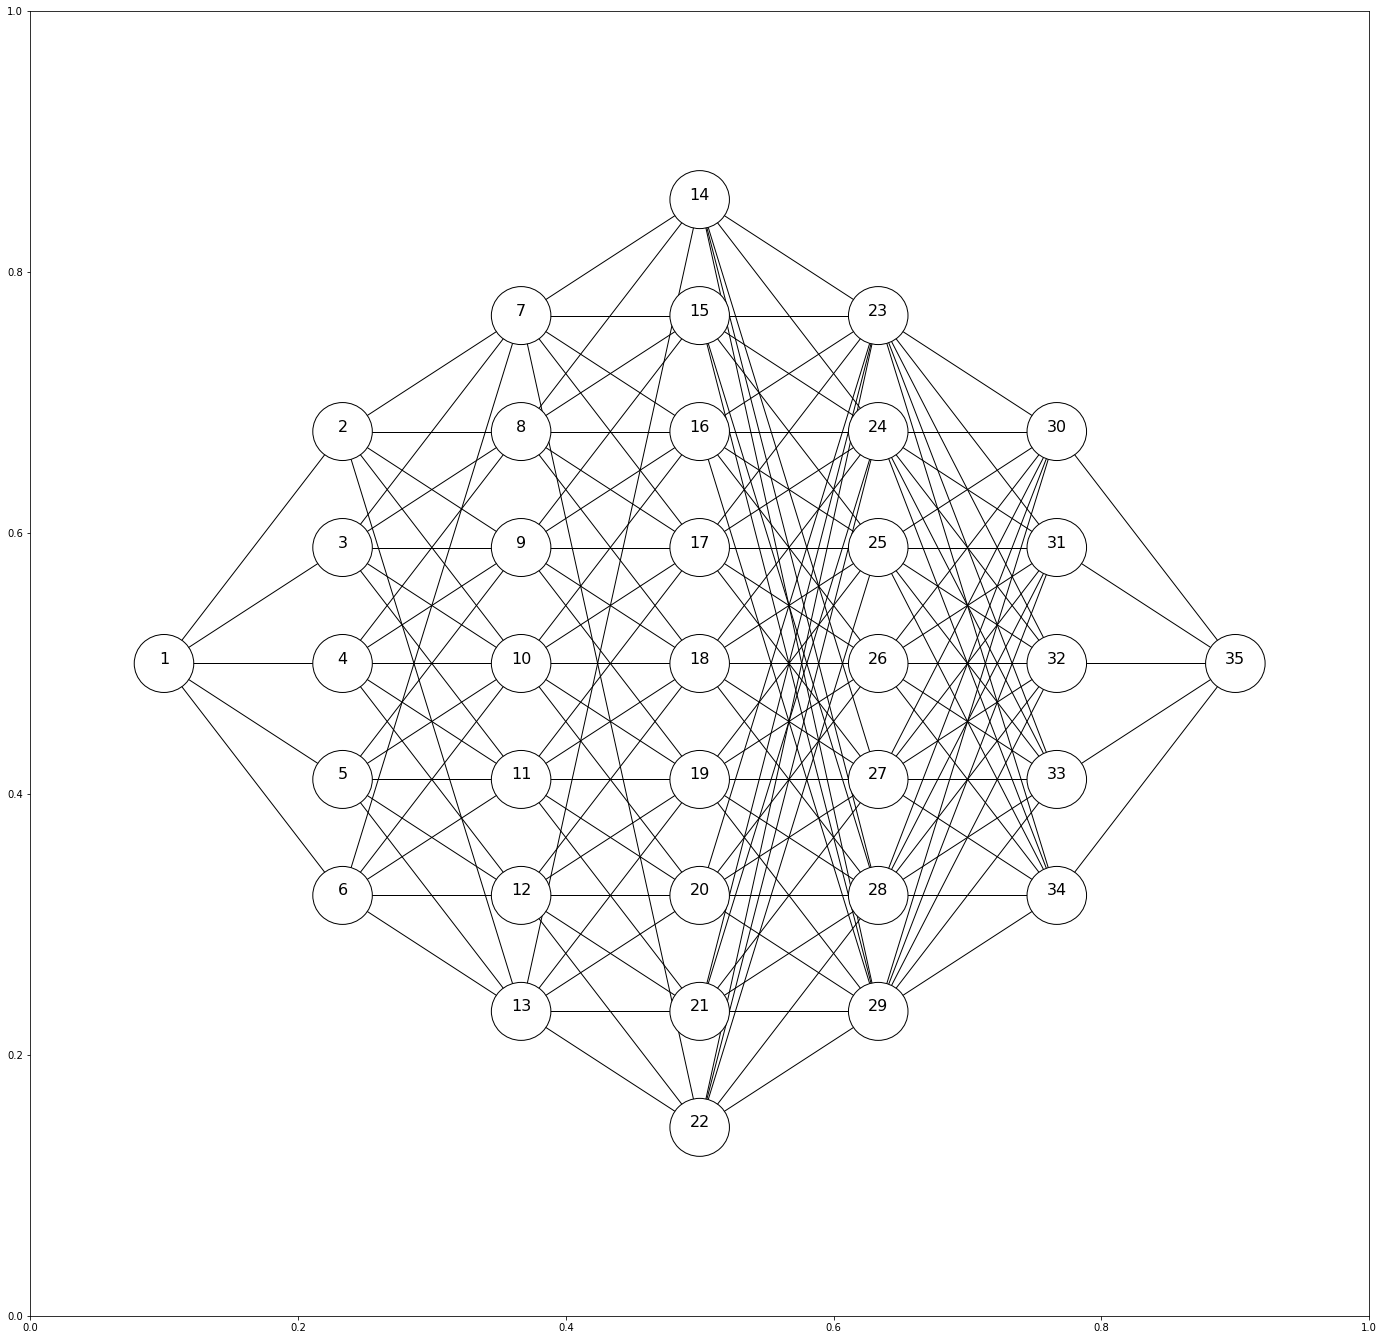

In [4]:
ward = Network(5,3) 

# print(ward.path_greedy(ward.start))
ward.draw_graph(plt.figure(figsize=(24, 24)).gca())
# print(ward.get_range(4))


# print(ward.path_random(ward.start))
# print(ward.path_dijkstra(ward.start,ward.end, True))


# # neighbour check
# for vert in sorted(ward.vertices):
#     print(vert , [den.get_key() for den in ward.vertices[vert].get_neighbours()])

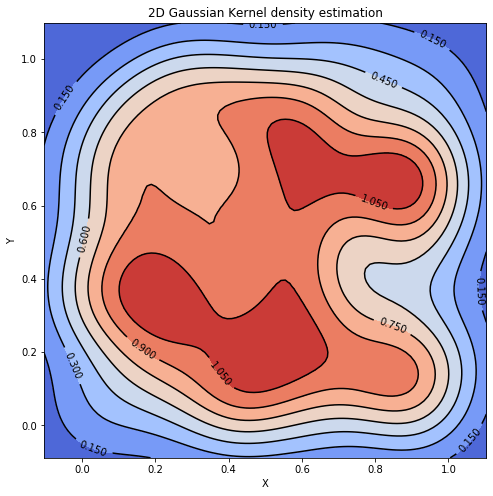

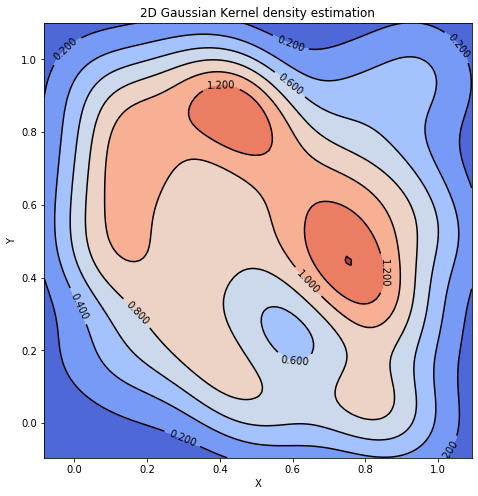

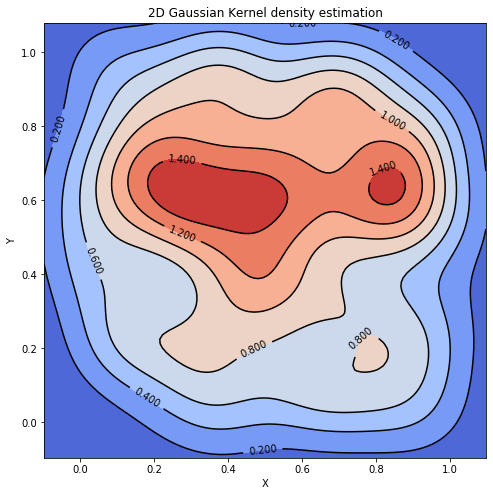

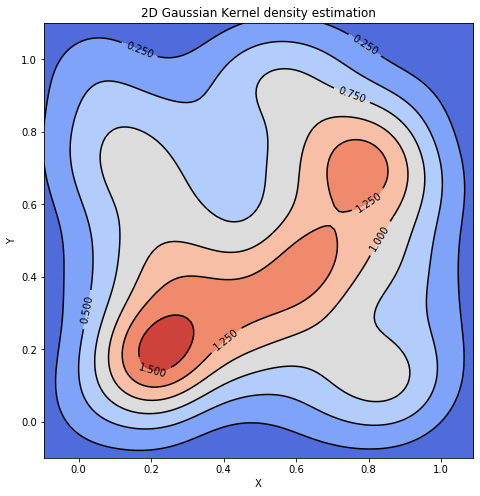

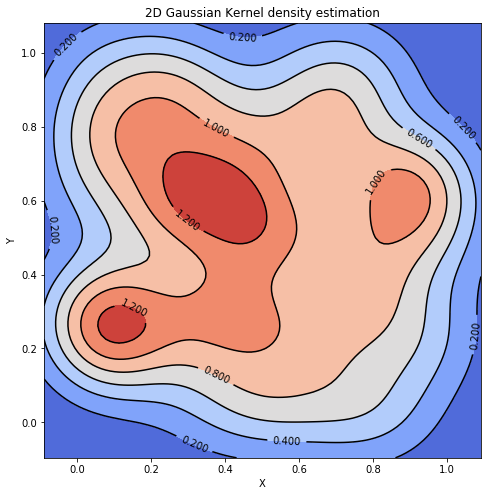

In [36]:
for i in range(51,56):
    n_components = 120
    X, truth = make_blobs(n_samples=300, centers=n_components, 
                          cluster_std = [0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001, 0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001, 0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001, 0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001,0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001, 0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001, 0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001, 0.002, 0.001, 0.005, 0.001, 0.0011,0.002,0.004,0.0013,0.001,0.008,0.005,0.003,0.006,0.004,0.001], 
                          random_state=i,center_box=(0,1))
    # plt.scatter(X[:, 0], X[:, 1], s=50, c = truth)
    # plt.title(f"Example of a mixture of {n_components} distributions")
    # plt.xlabel("x")
    # plt.ylabel("y");

    # Extract x and y
    x = X[:, 0]
    y = X[:, 1]

    # xmaxdiff = max(x) - 1
    # xrelmax = xmaxdiff/(abs(min(x)) + max(x))
    # xrelmin = -min(x)/(abs(min(x)) + max(x))
    # xma = 1000 - int(xrelmax* 1000) 
    # xmi = int(xrelmin* 1000)

    # ymaxdiff = max(y) - 1
    # yrelmax = ymaxdiff/(abs(min(y)) + max(y))
    # yrelmin = -min(y)/(abs(min(y)) + max(y))
    # yma = 1000 - int(yrelmax* 1000) 
    # ymi = int(yrelmin* 1000)


    # Define the borders
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY

    # xmin, ymin = -0.2, 1.2
    # xmax, ymax = -0.2, 1.2
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

    #######
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)

    f = np.reshape(kernel(positions).T, xx.shape)
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    cfset = ax.contourf(xx, yy, f, cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
    ax.imshow(np.rot90(f), cmap='coolwarm')
    cset = ax.contour(xx, yy, f, colors='k')
    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.title('2D Gaussian Kernel density estimation')

f = np.rot90(f)
# print(f[75][70])
# print(f[0])
# #####
# plt.figure(figsize=(8,8))
# for j in range(len(cset.allsegs)):
#     for ii, seg in enumerate(cset.allsegs[j]):
#         plt.plot(seg[:,0], seg[:,1], '.-', label=f'Cluster{j}, level{ii}')
# plt.legend()


# ######
# fig = plt.figure(figsize=(13, 7)) [0.2, 0.1, 0.05, 0.1, 0.11,0.2,0.4,0.13,0.1,0.08,0.05,0.03,0.06,0.04,0.1, 0.2, 0.1, 0.05, 0.1, 0.11,0.2,0.4,0.13,0.1,0.08,0.05,0.03,0.06,0.04,0.1]
# ax = plt.axes(projection='3d')
# surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('PDF')
# ax.set_title('Surface plot of Gaussian 2D KDE')
# fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
# ax.view_init(60, 35)

In [26]:
print(len(f))

1000
